### [Structured support vector machine](https://en.wikipedia.org/wiki/Structured_support_vector_machine)

Sebastian Nowozin, Structured Learning and Prediction in Computer Vision Structured Learning and Prediction in Computer Vision

http://www.nowozin.net/sebastian/papers/nowozin2011structured-tutorial.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

[Pystruct](https://pystruct.github.io/) - structured prediction in Python

In [3]:
from pystruct.inference import inference_dispatch, compute_energy
from pystruct.utils import make_grid_edges

N = 5
K = 3

rnd = np.random.RandomState(2)
x = rnd.normal(size=(1, N, K))
pairwise = np.random.rand(K, K)
edges = make_grid_edges(x)
unaries = x.reshape(-1, K)

# argmax (decoding)
y = inference_dispatch(unaries, pairwise, edges, inference_method='max-product')
print(y)


# Check energy
energy = compute_energy(unaries, pairwise, edges, y)
print(energy)

# L[i,:] - one-hot encoding of y[i]
L = np.zeros((N, K))
for i in range(N):
    L[i,y[i]] = 1

eng = np.sum(unaries*L)    
#eng = np.sum(unaries[range(N), y])    
    
for i in range(N-1):
    eng = eng + pairwise[y[i], y[i+1]] 
    #eng = np.dot(L[i,:], np.dot(pairwise, L[i+1,:].T))

print(eng)

assert(np.abs(energy - eng) < 1e-5)

[1 0 0 2 2]
6.841174120752752
6.841174120752752


In [4]:
from pystruct.datasets import load_letters

letters = load_letters()
data_list, labels_list, folds = letters['data'], letters['labels'], letters['folds']

abc = "abcdefghijklmnopqrstuvwxyz"

In [5]:
print(len(data_list))
print(len(labels_list))

6877
6877


In [6]:
print(folds)

[0 7 8 ... 4 5 9]


In [7]:
i = 2

print([abc[t] for t in labels_list[i]])

['o', 'm', 'm', 'a', 'n', 'd', 'i', 'n', 'g']


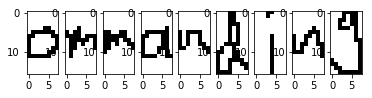

In [8]:
X = data_list[i]

fig, ax = plt.subplots(1, len(labels_list[i]))
for t in range(len(labels_list[i])):
    ax[t].imshow(X[t,:].reshape(16, 8), cmap=plt.cm.Greys)
plt.show()

In [9]:
print(np.hstack(labels_list)[0:20])

[14 12 12  0 13  3  8 13  6 14 12 12  0 13  3  8 13  6 14 12]


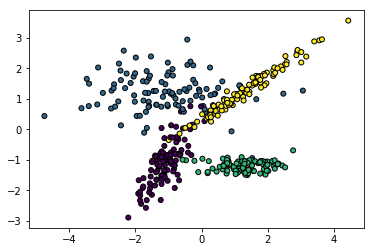

In [10]:
from sklearn.datasets import make_classification

K = 4 # number of classes

X, y = make_classification(n_samples=400, n_features=2, class_sep=1.2,
                           n_redundant=0, n_informative=2, 
                              n_clusters_per_class=1, n_classes=K, random_state=1)

plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()

In [11]:
data_list = []
labels_list = []

L = X.shape[0]

stop = False
idx = 0
while True:
    n = np.random.poisson(10)
    if idx+n < L:
        data_list.append(X[idx:idx+n,:])
        labels_list.append(y[idx:idx+n])
        idx = idx + n
    else:
        data_list.append(X[idx:,:])
        labels_list.append(y[idx:])
        stop = True
    if stop:
        break
        
print(len(data_list), len(labels_list))

42 42


In [12]:
def unpack_params(theta, K):
    W = theta.reshape(K, -1)
    b = W[:, -1]
    W = W[:, :-1]
    return W, b

In [13]:
def unpack_params_structured(theta, K):
    AWb = theta.reshape(K, -1)
    A = AWb[:,:K]
    Wb = AWb[:,K:]
    b = Wb[:, -1]
    W = Wb[:, :-1]
    return A, W, b

In [14]:
from pystruct.inference.maxprod import inference_max_product

def predict_aka_decoding(theta, X, K):
    N = X.shape[0]
    W,b = unpack_params(theta, K)
    scores = np.dot(X, W.T) + b.T
    return np.argmax(scores, axis=1)
    #return inference_max_product(scores, np.zeros((K,K)), np.c_[np.arange(0,N-1), np.arange(1, N)])

In [15]:
def predict_aka_decoding_structured(theta, X, K):
    N = X.shape[0]
    A,W,b = unpack_params_structured(theta, K)
    unaries = np.dot(X, W.T) + b.T
    pairwise = A
    edges = np.c_[np.arange(0,N-1), np.arange(1, N)]
    return inference_max_product(unaries, pairwise, edges)

In [16]:
def loss_augmented_decoding(theta, X, y, K):    
   
    N = X.shape[0]
    
    W,b = unpack_params(theta, K)
    scores = np.dot(X, W.T) + b.T
    
    #idx = np.argsort(scores, axis=1) 
    #idx_max1 = idx[:,-1]
    #idx_max2 = idx[:,-2]     
    #d1 = scores[range(N),idx_max1] - scores[range(N),y]
    #d2 = scores[range(N),y] - scores[range(N),idx_max2]
    #y_hat = (d1>0)*idx_max1 + (d1==0)*(d2>1)*y + (d1==0)*(d2<1)*idx_max2  
    
    scores[range(N),y] -=1
    #y_hat = np.argmax(scores, axis=1)
    edges = np.c_[np.arange(0,N-1), np.arange(1, N)]
    y_hat = inference_max_product(scores, np.zeros((K,K)), edges)
    
    return y_hat

In [17]:
def loss_augmented_decoding_structured(theta, X, y, K):    
    
    N = X.shape[0]
    
    A,W,b = unpack_params_structured(theta, K)
    scores = np.dot(X, W.T) + b.T
    
    scores[range(N),y] -=1
    edges = np.c_[np.arange(0,N-1), np.arange(1, N)]
    y_hat = inference_max_product(scores, A, edges)
    
    return y_hat

In [18]:
from pystruct.inference import compute_energy
from sklearn.preprocessing import LabelBinarizer

def risk_and_gradient(theta, data_list, labels_list, K, beta):
    
    N = len(data_list)
    
    #W,b = unpack_params(theta, K)
    A,W,b = unpack_params_structured(theta, K)
    
    loss = np.zeros((N,))
    grad_A = beta*A
    grad_W = beta*W
    grad_b = beta*b
    
    lb = LabelBinarizer()
    lb.fit(np.hstack(labels_list))
    
    for i in range(N):
        X = data_list[i]
        y = labels_list[i]
        
        # loss-augmented decoding (separation oracle)
        #y_hat = loss_augmented_decoding(theta, X, y, K)
        y_hat = loss_augmented_decoding_structured(theta, X, y, K)
        unaries = np.dot(X, W.T) + b.T
        
        n = X.shape[0]
        #pairwise = np.zeros((K,K)) # A
        pairwise = A
        edges = np.c_[np.arange(0,n-1), np.arange(1, n)]
        
        energies = compute_energy(unaries, pairwise, edges, y)
        energies_hat = compute_energy(unaries, pairwise, edges, y_hat)
        delta = np.sum(y != y_hat) # Hamming loss
        
        loss[i] = -energies + energies_hat + delta  
        
        if loss[i] > 0:  

            Y = lb.transform(y)
            Y_hat = lb.transform(y_hat)
            grad_W = grad_W + 1/N*(np.dot(Y_hat.T, X) - np.dot(Y.T, X))
            grad_b = grad_b + 1/N*(np.sum(Y_hat, axis=0) - np.sum(Y, axis=0))
            '''
            for k in range(K):        
                idx_k_hat = y_hat==k
                idx_k = y==k
                grad_W[k,:] = grad_W[k,:] + 1/N*(np.sum(X[idx_k_hat,:], axis=0) - np.sum(X[idx_k,:], axis=0))
                grad_b[k] = grad_b[k] + 1/N*(np.sum(idx_k_hat) - np.sum(idx_k))
            '''
            grad_A = grad_A + 1/N*(np.dot(Y_hat[:-1,:].T, Y_hat[1:,:]) - np.dot(Y[:-1,:].T, Y[1:,:]))

    # risk
    risk = 1/N*np.sum(loss) + 0.5*beta*np.sum(theta**2)  
    
    # gradient     
    #gradient = np.hstack((grad_W, grad_b[:,np.newaxis]))
    gradient = np.hstack((grad_A, grad_W, grad_b[:,np.newaxis]))
    
    return risk, gradient.flatten()

In [19]:
def approx_grad(f, x0):
    epsilon = 1e-5
    dim = len(x0)
    grad = np.zeros((dim,))
    e = np.zeros((dim,))
    for k in range(dim):
        e[k] = epsilon
        grad[k] = (f(x0 + e) - f(x0))/epsilon
        e[k] = 0
    return grad

In [20]:
# gradient checking
dim = X.shape[1]
w0_ = np.random.randn(dim*K + K*K + K,)

lmbda = 0.1

func = lambda w: risk_and_gradient(w, data_list, labels_list, K, lmbda)[0]
gradient = lambda w: risk_and_gradient(w, data_list, labels_list, K, lmbda)[1]

numerical_gradient = approx_grad(func, w0_)
analytical_gradient = gradient(w0_)

from scipy.linalg import norm

print(np.c_[numerical_gradient, analytical_gradient])

diff = norm(numerical_gradient - analytical_gradient)/norm(numerical_gradient + analytical_gradient)

print(diff)

[[-0.7635868  -0.7635873 ]
 [ 0.064302    0.0643015 ]
 [-0.3984759  -0.3984764 ]
 [ 0.42749914  0.42749864]
 [ 0.55904709  0.55904659]
 [ 1.16212464  1.16212414]
 [-0.48822431 -0.48822481]
 [ 0.23822936  0.23822886]
 [ 1.01917753  1.01917703]
 [ 0.88881856  0.88881806]
 [-0.2012819  -0.2012824 ]
 [ 3.00178442  3.00178392]
 [-3.0593707  -3.0593712 ]
 [ 2.09399169  2.09399119]
 [ 0.18823076  0.18823026]
 [-0.42997275 -0.42997325]
 [-0.7479123  -0.7479128 ]
 [-0.2306595  -0.23066   ]
 [ 0.0825099   0.0825094 ]
 [ 1.77798078  1.77798028]
 [-0.77422511 -0.77422561]
 [-0.32318889 -0.32318939]
 [ 0.82958676  0.82958626]
 [-0.66177679 -0.66177729]
 [-0.26100518 -0.26100568]
 [-3.35761226 -3.35761276]
 [ 0.08377782  0.08377732]
 [-0.65462311 -0.65462361]]
1.9698807081191e-07


In [21]:
# Gradient descent optimizer
def fmin_gd(objective, x_init, stepsize=0.04, max_iter=1000):
    alpha = stepsize
    x = x_init
    for i in range(max_iter):
        f_val, gradient = objective(x)
        x = x - alpha*gradient
        alpha = alpha*0.9999
    return x 

In [22]:
# Adam optimizer
def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
        g = grad(x)
        if callback: callback(x, i, g)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [23]:
lmbda = 0.01

theta_init = np.random.randn(dim*K + K*K + K,)

#objective = lambda w: risk_and_gradient(w, data_list, labels_list, K, lmbda)
#theta_opt = fmin_gd(objective, theta_init, stepsize=0.05, max_iter=300)

gradient = lambda w: risk_and_gradient(w, data_list, labels_list, K, lmbda)[1]
theta_opt = adam(gradient, theta_init, num_iters=300, step_size=0.05)

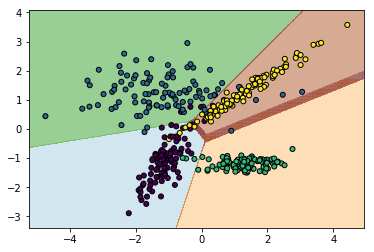

In [25]:
h = .01  # step size in the mesh

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

X_test = np.c_[xx.ravel(), yy.ravel()]

#Z = predict_aka_decoding(theta_opt, X_test, K).reshape(xx.shape)
Z = predict_aka_decoding_structured(theta_opt, X_test, K).reshape(xx.shape)

plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=.5)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25, edgecolor='k')
plt.show()